# Bert for Sequence Classification Fine TUning


In [ ]:
# mount the disk in Colab 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install the pretrained bert model for pytorch 

!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 123 kB 13.3 MB/s 
     |████████████████████████████████| 90 kB 8.5 MB/s 
     |████████████████████████████████| 131 kB 46.7 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 8.5 MB 50.9 MB/s 
     |████████████████████████████████| 138 kB 47.5 MB/s 
     |████████████████████████████████| 127 kB 46.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# install the hugging face library

!pip install transformers

     |████████████████████████████████| 3.4 MB 5.9 MB/s 
     |████████████████████████████████| 3.3 MB 27.9 MB/s 
     |████████████████████████████████| 895 kB 29.9 MB/s 
     |████████████████████████████████| 596 kB 37.4 MB/s 
     |████████████████████████████████| 61 kB 465 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
#from pytorch_transformers import BertAdam
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
# set some parametrs in pandas to display all the rows of the dataframe 
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [ ]:
# check if we have mounted any GPU
if torch.cuda.is_available():    

    # initialize if there is a GPU   
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
# Read the dataset with pandas (if the dimension allows to store it in one file) , important to chose the rigth encoding and sep 
# We use the ABSITA dataset for the EVALITA 2018 task : you can find the relative paper guideline in the directory 

sentences_text = pd.read_csv('drive/MyDrive/Colab Notebooks/NLP course/dataset/absita_2018_training.csv'
                             ,
                             sep=";"
                             #, encoding='cp1252'
                             )

1    0.573379
0    0.426621
Name: cleanliness_positive, dtype: float64


In [ ]:
sentences_text.head(2)

,sentence_id,cleanliness_presence,cleanliness_positive,cleanliness_negative,comfort_presence,comfort_positive,comfort_negative,amenities_presence,amenities_positive,amenities_negative,staff_presence,staff_positive,staff_negative,value_presence,value_positive,value_negative,wifi_presence,wifi_positive,wifi_negative,location_presence,location_positive,location_negative,other_presence,other_positive,other_negative,sentence
1,1240351476,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"stanza enorme e pulita, con letto comodissimo."
4,1240345146,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"l'hotel avrebbe bisogno di una ripulita, non tanto le stanze dato che la mia era spaziosa e confortevole, ma il corridoio e la moquette."


Before applying any predictive model we need to make same analysis on the text and in case (basically in any real world problem !) doing some pre-processing. 
In this case, we need to lowercase the text (as we are going to use a Bert model based on uncased characters) and select the target variables. 

In [ ]:
import regex as re

sentences_text['sentence'] = sentences_text.sentence.str.lower()

sentences_text_sub = sentences_text[sentences_text['cleanliness_presence'] == 1]

print(sentences_text_sub['cleanliness_positive'].value_counts(normalize = True) )

In [ ]:
# Create sentence and label lists
sentences = sentences_text_sub.sentence.values
labels = sentences_text_sub.cleanliness_positive.values

In [ ]:
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel

# The model for Italian that we will use is called ALBERTo, the Github link is : https://github.com/marcopoli/AlBERTo-it  while the paper : http://ceur-ws.org/Vol-2481/paper57.pdf
model_name_pretrained = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"

# Firstly, we need to get the model's tokenizer. It is important that the tokenizer is the same of the model 
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = model_name_pretrained)

# find the maximum length 
max_len = 0
seq_len = list()

# For every sentence...
for sent in tqdm(sentences):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # get length of all the messages in the train set
    seq_len.append(len(input_ids))

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Loading tokenizer...


  0%|          | 0/879 [00:00<?, ?it/s]

Max sentence length:  96


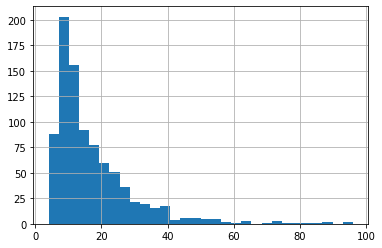

In [ ]:
# get length of all the messages in the train set
#seq_len = [len(i.split()) for i in sentences]

pd.Series(seq_len).hist(bins = 30)

Before proced we need to keep in mind some formatting rules that BERT needs in its syntax. Firstly, the are some **special characters** that we must incorporate in the dataset for the fine tuning task at the START and the END of each sentence (1). As in other seq2seq models we need to **pad** the sequences and **truncate** (2). Lastly, the tokens need to be esplicity **masked** (3). This derives from the mechanism of masking that is used in the pre-train phase.

## Special Characters

the [SEP] token (it has an ID as all the other words) specifies the end of a sentence. In the pre-train phase is used in the 2 sentence task. Even if in this fine task we have just one sentence it is required anyway to detect the END phrase. 

the [CLS] token is used to specify the START of the sentence. We need to add it because at the end of the propragation trough the transformers ( 12 or 24 depending of which BERT model we are using) the model will use the first token embedding to predict the class. 

## Padding and sentence length

In BERT models there is a fixed length limit of 512 tokens. In the dataset the sentences could have different length so we want to truncate longer sentences and add the [PAD] token to the shorter sentences. 
Ad example if we have the sentence " I love the sea. " this must be converted in 

"[CLS] I love the sea. [SEP] [PAD] ....... [PAD]" 

Is this enough to feed our BERT model? no yet! the last step before we proceed to feed the input and obtain our prediction is to add an attention layer mask. It consists of a sequence of 0 and 1 that explicits the token to mask. In our example :

"[CLS] I love the sea. [SEP] [PAD] ....... [PAD]"

----1----1---1----1----1-----1--------0----.......---0

The mask layer tells to the attention layer of the transformers to not consider the masked tokens. 

In [ ]:


# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

for sent in tqdm(sentences):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                           # Sentence to encode.
                        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                        max_length = 100,                # Pad & truncate all sentences.
                        return_token_type_ids= False,
                        pad_to_max_length = True,
                        truncation = True,       
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',          # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.

print('Original: ', sentences[0])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize( sentences[0] ))
print('Token IDs:', input_ids[0])
print('Mask: ', attention_masks[0])

  0%|          | 0/879 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  stanza enorme e pulita, con letto comodissimo.
Tokenized:  ['stanza', 'enorme', 'e', 'pulita', '[UNK]', 'con', 'letto', 'comodissimo', '[UNK]']
Token IDs: tensor([    2,  2205,  2759,    13,  5827,     1,    35,   329, 48530,     1,
            3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy constru

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import AutoTokenizer, AutoModel
from transformers import (AutoConfig, 
                          AutoModelForSequenceClassification, 
                          AutoTokenizer, AdamW, 
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model_name_or_path = 'bert-base-uncased'
model_name_pretrained = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"

# Get model configuration.
#print('Loading configuraiton...')
#model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path = model_name_or_path, 
#                                          num_labels=2)

# Get the actual model.
print('Loading model...')
model_seq = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path = model_name_pretrained, 
                                                            #config = model_config,
                                                           num_labels=2,
                                                           ignore_mismatched_sizes=True)

Loading model...


Downloading:   0%|          | 0.00/706M [00:00<?, ?B/s]

Some weights of the model checkpoint at m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

In [ ]:
# push the model to GPU
model_seq = model_seq.to(device)

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model_seq.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (128000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

NameError: ignored

# Main: training and evaluation

In [ ]:
param_optimizer = list(model_seq.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification

# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=5e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
b_input_ids[0]

tensor([   2, 6198,  313, 5963,  155, 9592, 5827,    1,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = list()
val_loss_set = list()

# Set initial value for validation loss
best_val_loss = float('inf')

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  ## TRAINING
  
  # Set our model to training mode (this allows the model to change the parameters during train)
  model_seq.train()
  
  #
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    
    # Add batch to GPU 
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    
    outputs = model_seq(input_ids = b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    #output = model_seq(**inputs)
    
    loss = outputs.loss

    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()

    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model_seq.eval()

  # Tracking variables 
  eval_loss = 0
  eval_accuracy = 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs_val = model_seq(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)
    
    loss_val = outputs_val.loss
    logits = outputs_val.logits
    
    # Update tracking variables
    eval_loss += loss_val.item()
    val_loss_set.append(loss_val.item())

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  

  mean_loss = (eval_loss/nb_eval_steps)

  print(f'\Validation Loss: {mean_loss:.5f}')
  #print("Validation loss: {}".format(eval_loss/nb_eval_steps))
  
  print(f'\Validation Accuracy: {eval_accuracy/nb_eval_steps):.3f}')
  #print("- Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

  #save the best model
  if mean_loss < best_val_loss:
        best_val_loss = mean_loss
        torch.save(model_seq.state_dict(), 'saved_weights.pt')

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.5588891841471195


Epoch:  25%|██▌       | 1/4 [00:33<01:41, 33.80s/it]

Validation Accuracy: 0.9270833333333334
Train loss: 0.34737309157848356


Epoch:  50%|█████     | 2/4 [01:07<01:07, 33.76s/it]

Validation Accuracy: 0.9375
Train loss: 0.3749317355453968


Epoch:  75%|███████▌  | 3/4 [01:41<00:33, 33.77s/it]

Validation Accuracy: 0.8229166666666666
Train loss: 0.6332312819361686


Epoch: 100%|██████████| 4/4 [02:15<00:00, 33.78s/it]

Validation Accuracy: 0.5833333333333334


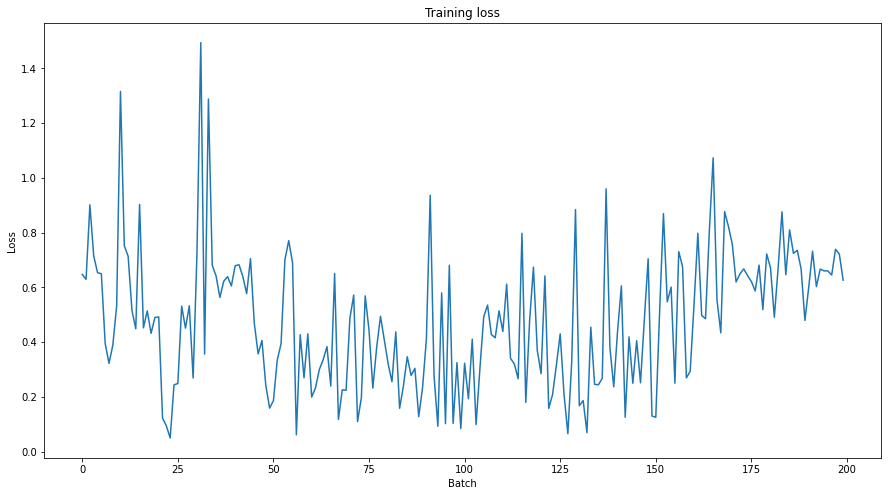

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Test set evaluation 

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

Let's test the model on a test set called 'absita_2018_test_clean.csv'. 

The step are the following: 

* read the dataset
* select the target and lower case
* tokenize the sentences with the tokenizer 
* create the dataloaders
* evaluate the model and compute the accuracy